<a href="https://www.kaggle.com/code/bagmitathakur/notebook-microbusiness?scriptVersionId=119999435" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tqdm.notebook import tqdm


In [3]:
census_df=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
census_df.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [4]:
train_df=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
print(train_df.isnull().sum())
train_df.head()

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [5]:
train_df['first_day_of_month']=pd.to_datetime(train_df.first_day_of_month,format='%Y-%m-%d')
train_df['DATE']=train_df['first_day_of_month']
train_df.drop(columns=['first_day_of_month'],axis=1,inplace=True)
train_df.head()




,row_id,cfips,county,state,microbusiness_density,active,DATE
0,1001_2019-08-01,1001,Autauga County,Alabama,3.007682,1249,2019-08-01
1,1001_2019-09-01,1001,Autauga County,Alabama,2.884870,1198,2019-09-01
2,1001_2019-10-01,1001,Autauga County,Alabama,3.055843,1269,2019-10-01
3,1001_2019-11-01,1001,Autauga County,Alabama,2.993233,1243,2019-11-01
4,1001_2019-12-01,1001,Autauga County,Alabama,2.993233,1243,2019-12-01


In [6]:
test_df=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
test_df.first_day_of_month=pd.to_datetime(test_df.first_day_of_month,format='%Y-%m-%d')
test_df['DATE']=test_df['first_day_of_month']
test_df.drop(columns=['first_day_of_month'],axis=1,inplace=True)
test_df.head()

,row_id,cfips,DATE
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [7]:
import warnings
warnings.filterwarnings("ignore")
df_new=train_df.merge(test_df,how='outer')
df_n=df_new.set_index('DATE')
df_n.head()

,row_id,cfips,county,state,microbusiness_density,active
DATE,,,,,,
2019-08-01,1001_2019-08-01,1001,Autauga County,Alabama,3.007682,1249.0
2019-09-01,1001_2019-09-01,1001,Autauga County,Alabama,2.884870,1198.0
2019-10-01,1001_2019-10-01,1001,Autauga County,Alabama,3.055843,1269.0
2019-11-01,1001_2019-11-01,1001,Autauga County,Alabama,2.993233,1243.0
2019-12-01,1001_2019-12-01,1001,Autauga County,Alabama,2.993233,1243.0


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

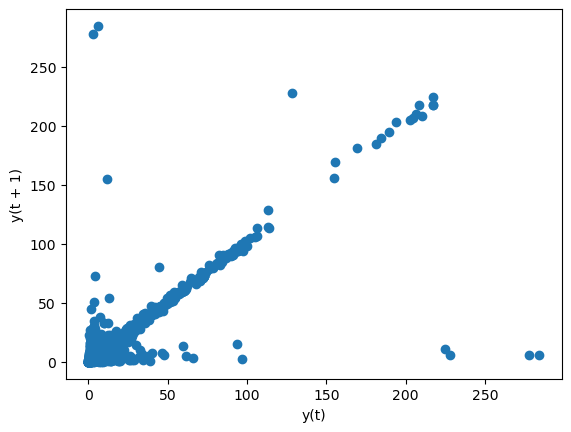

In [8]:
from pandas.plotting import lag_plot
lag_plot(df_n['microbusiness_density'])

In [9]:
corr_df=pd.DataFrame()
corr_df['t']=df_n['microbusiness_density']
corr_df['t-1']=df_n['microbusiness_density'].shift(1)
print("Lag-1 correlation coefficient:")
print(corr_df.corr())
corr_df

Lag-1 correlation coefficient:
           t      t-1
t    1.00000  0.91075
t-1  0.91075  1.00000


,t,t-1
DATE,,
2019-08-01,3.007682,NaN
2019-09-01,2.884870,3.007682
2019-10-01,3.055843,2.884870
2019-11-01,2.993233,3.055843
2019-12-01,2.993233,2.993233
...,...,...
2023-06-01,NaN,NaN
2023-06-01,NaN,NaN
2023-06-01,NaN,NaN


In [10]:
mc_df=pd.DataFrame()
mc_df['DATE']=df_new['DATE'].copy(deep=True)
mc_df['microbusiness_density']=df_new['microbusiness_density'].copy(deep=True)
mc_df.dropna(inplace=True)
mc_df=mc_df.set_index('DATE')
mc_df

,microbusiness_density
DATE,
2019-08-01,3.007682
2019-09-01,2.884870
2019-10-01,3.055843
2019-11-01,2.993233
2019-12-01,2.993233
...,...
2022-06-01,1.803249
2022-07-01,1.803249
2022-08-01,1.785395


In [11]:
mc_df=mc_df.groupby(mc_df.index).mean()
mc_df

,microbusiness_density
DATE,
2019-08-01,3.749621
2019-09-01,3.696846
2019-10-01,3.778263
2019-11-01,3.722510
2019-12-01,3.717284
2020-01-01,3.689041
2020-02-01,3.635546
2020-03-01,3.648742
2020-04-01,3.700048


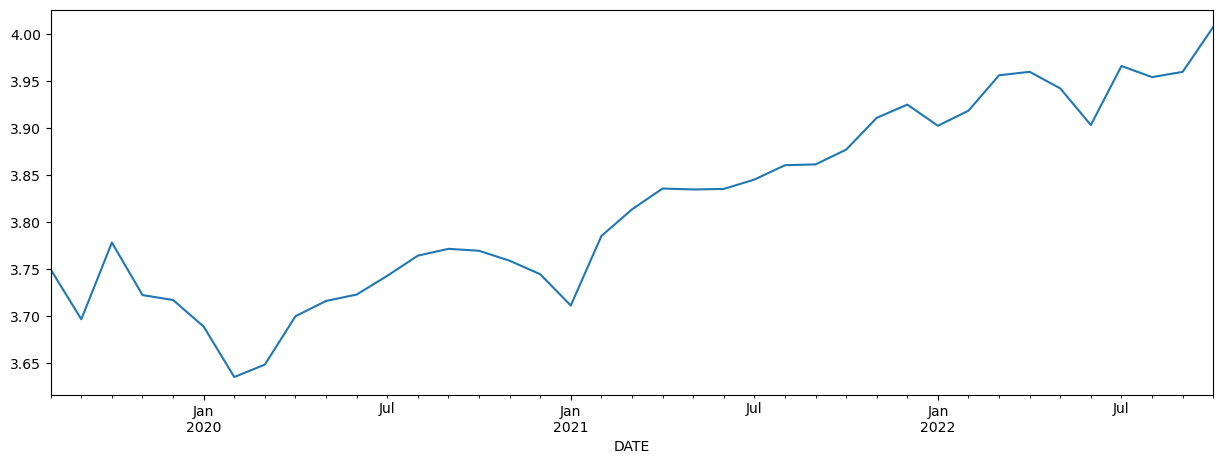

In [12]:
plt.figure(figsize = (15,5))
mc_df['microbusiness_density'].plot();


plotting seasonal_decompose graph with additive model

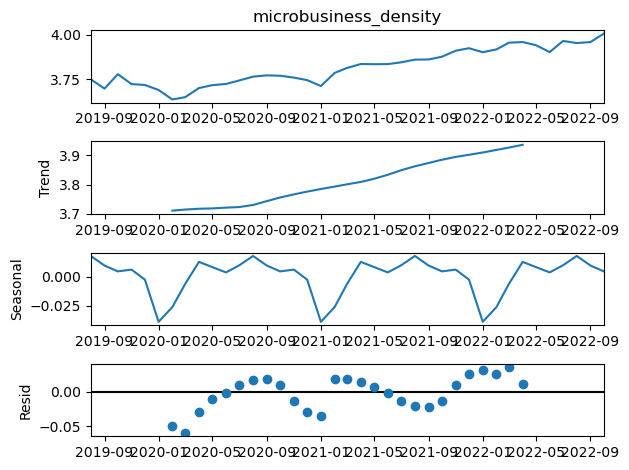

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
sm_pl = seasonal_decompose(mc_df['microbusiness_density'],period = 12,model = 'additive').plot()
plt.show()


plotting seasonal_decompose graph with multiplicative model

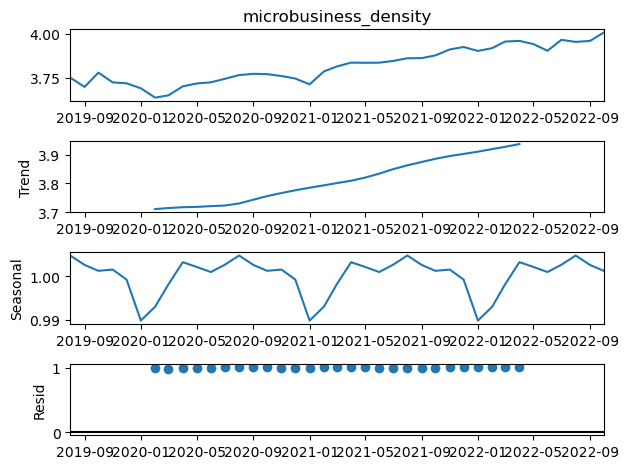

In [14]:

sm_pl = seasonal_decompose(mc_df['microbusiness_density'],period = 12,model = 'multiplicative').plot()
plt.show()


ROLLING STATISTICS TEST

In [15]:

roll_mean = mc_df.rolling(window = 12).mean() # gives rolling mean at yearly level
roll_std = mc_df.rolling(window = 12).std()   # gives rolling std at yearly level

print('Rolling Mean')
print(roll_mean.head(20))
print('-----------------------------')
print('Rolling Standard Deviation')
print(roll_std.head(20))

Rolling Mean
            microbusiness_density
DATE                             
2019-08-01                    NaN
2019-09-01                    NaN
2019-10-01                    NaN
2019-11-01                    NaN
2019-12-01                    NaN
2020-01-01                    NaN
2020-02-01                    NaN
2020-03-01                    NaN
2020-04-01                    NaN
2020-05-01                    NaN
2020-06-01                    NaN
2020-07-01               3.710015
2020-08-01               3.711240
2020-09-01               3.717466
2020-10-01               3.716738
2020-11-01               3.719777
2020-12-01               3.722057
2021-01-01               3.723922
2021-02-01               3.736391
2021-03-01               3.750115
-----------------------------
Rolling Standard Deviation
            microbusiness_density
DATE                             
2019-08-01                    NaN
2019-09-01                    NaN
2019-10-01                    NaN
2019-11-01  

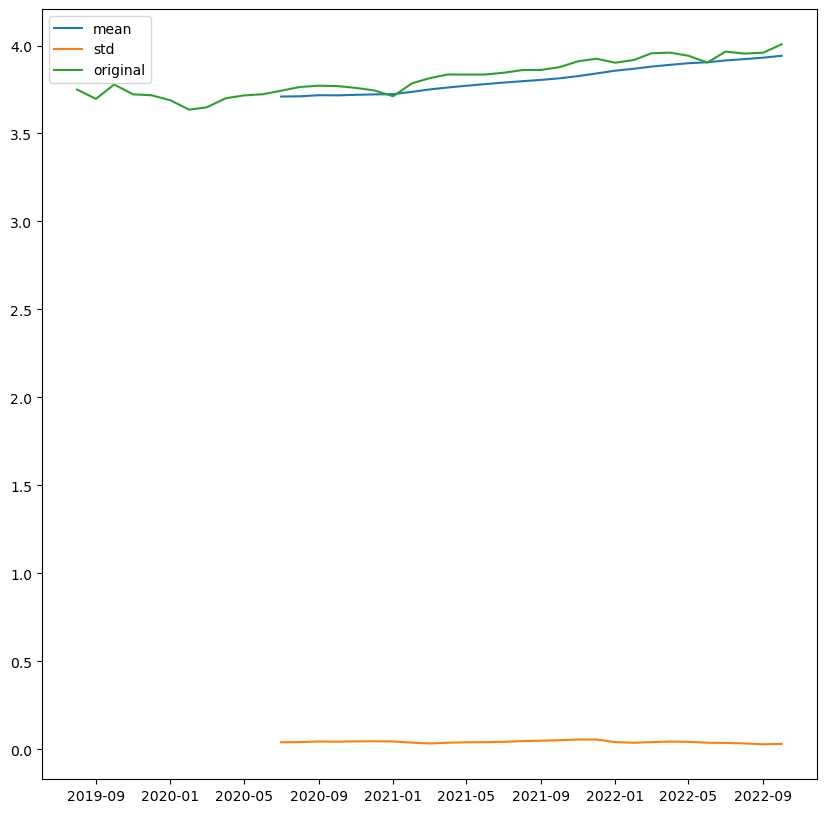

In [16]:
plt.figure(figsize=(10,10))
plt.plot(roll_mean,label='mean')
plt.plot(roll_std,label='std')
plt.plot(mc_df,label='original')
plt.legend()
plt.show()

doing rolling statistics test visuaisation with the mc_df dataset

DICKEY FULLER TEST

In [17]:
from statsmodels.tsa.stattools import adfuller
def adf_test(ts):
    df_test = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(df_test[0:4], index=['Test Stats','p-value','Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
adf_test(mc_df)

Test Stats                     -0.176712
p-value                         0.941241
Lags Used                       0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
dtype: float64
Test Stats                     -0.176712
p-value                         0.941241
Lags Used                       0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
dtype: float64
Test Stats                     -0.176712
p-value                         0.941241
Lags Used                       0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


HERE WE CANNOT REJECT THE NULL HYPOTHESIS AS THE TEST STATS IS NOT SIGNIFIVANTLY LOW AND p_VALUE IS >>0.05.Therefore the model is non stationary

[]

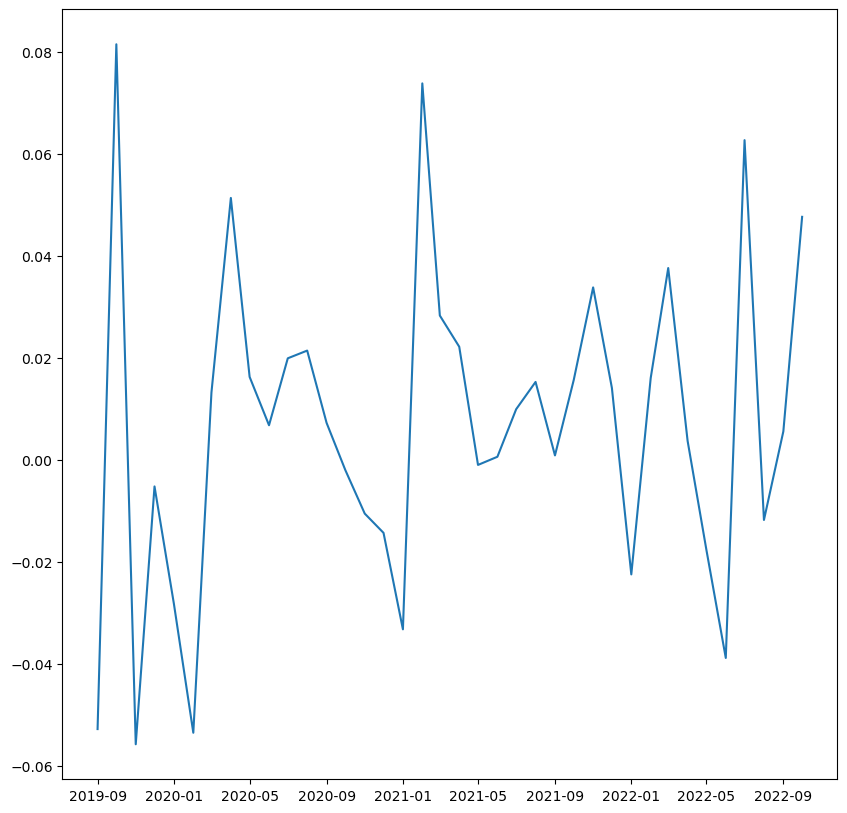

In [18]:
df_lag1=mc_df.diff(1)
df_lag1.dropna(inplace=True)
plt.figure(figsize=(10,10))
plt.plot(df_lag1)
plt.plot()

ROLLING STATS TEST ON THE DIFFERENTIATED DATASET


In [19]:
roll_mean1 = df_lag1.rolling(window = 12).mean() 
roll_std1 = df_lag1.rolling(window = 12).std()   

print('Rolling Mean')
print(roll_mean1.head(20))
print('-----------------------------')
print('Rolling Standard Deviation')
print(roll_std1.head(20))

Rolling Mean
            microbusiness_density
DATE                             
2019-09-01                    NaN
2019-10-01                    NaN
2019-11-01                    NaN
2019-12-01                    NaN
2020-01-01                    NaN
2020-02-01                    NaN
2020-03-01                    NaN
2020-04-01                    NaN
2020-05-01                    NaN
2020-06-01                    NaN
2020-07-01                    NaN
2020-08-01               0.001226
2020-09-01               0.006226
2020-10-01              -0.000728
2020-11-01               0.003039
2020-12-01               0.002280
2021-01-01               0.001865
2021-02-01               0.012469
2021-03-01               0.013724
2021-04-01               0.011295
-----------------------------
Rolling Standard Deviation
            microbusiness_density
DATE                             
2019-09-01                    NaN
2019-10-01                    NaN
2019-11-01                    NaN
2019-12-01  

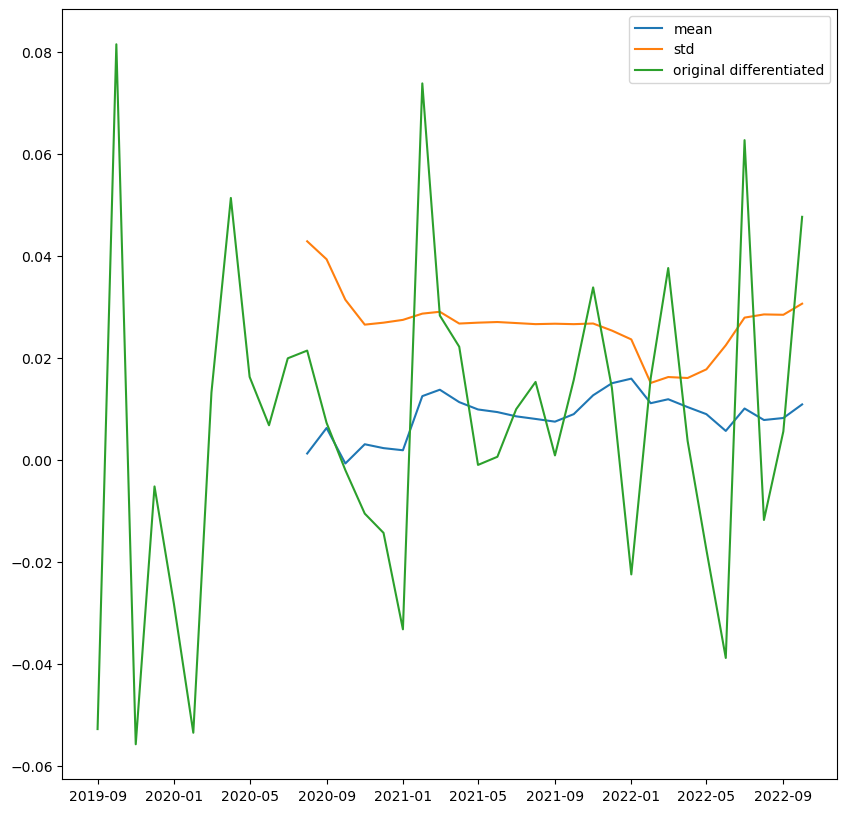

In [20]:
plt.figure(figsize=(10,10))
plt.plot(roll_mean1,label='mean')
plt.plot(roll_std1,label='std')
plt.plot(df_lag1,label='original differentiated')
plt.legend()
plt.show()

ADF TEST

In [21]:
adf_test(df_lag1)

Test Stats                     -4.592181
p-value                         0.000134
Lags Used                       1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
dtype: float64
Test Stats                     -4.592181
p-value                         0.000134
Lags Used                       1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
dtype: float64
Test Stats                     -4.592181
p-value                         0.000134
Lags Used                       1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


HERE WE CAN REJECT THE NULL HYPOTHESIS AND GO FOR THE ALTERNATE HYPOTHESIS BECAUSE p_value <5% and adf stats shows value< critical value hence the model has turned stationary .Therefore differentiating order d=1

plotting autocorrelation function plot

Figure(640x480)


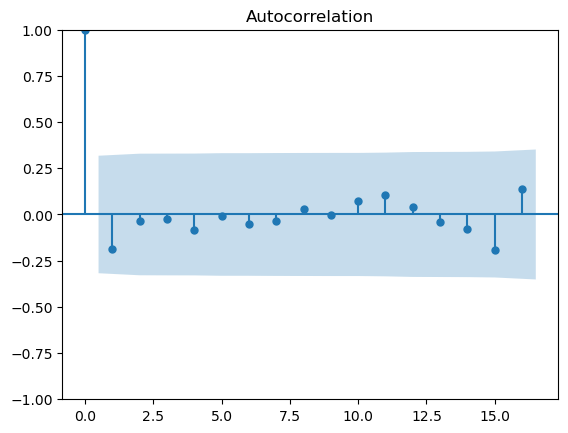

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
print(plot_acf(df_lag1))

from this graph the path turns out as sinosaudal so the order p of the Autoregression is 0

Figure(640x480)


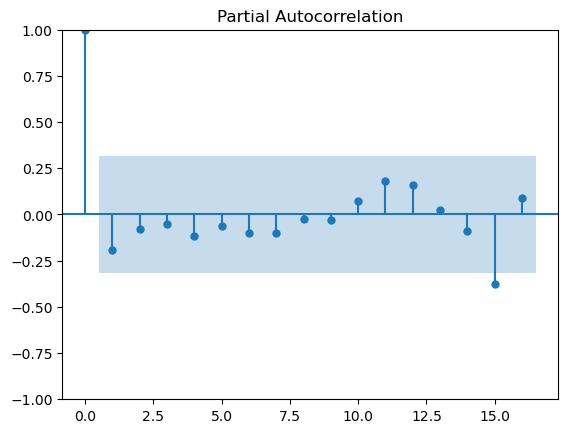

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
print(plot_pacf(df_lag1))


THE GRAPH SHOWS PATH AS SINOSAUDAL ,HENCE The order q of the moving average process is 0

In [24]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
arima_model=ARIMA(mc_df,order=(0,1,0)).fit()
print(arima_model.params)

sigma2    0.00107
dtype: float64


mae 0.0250554517444716
rmse 0.03271271750135382


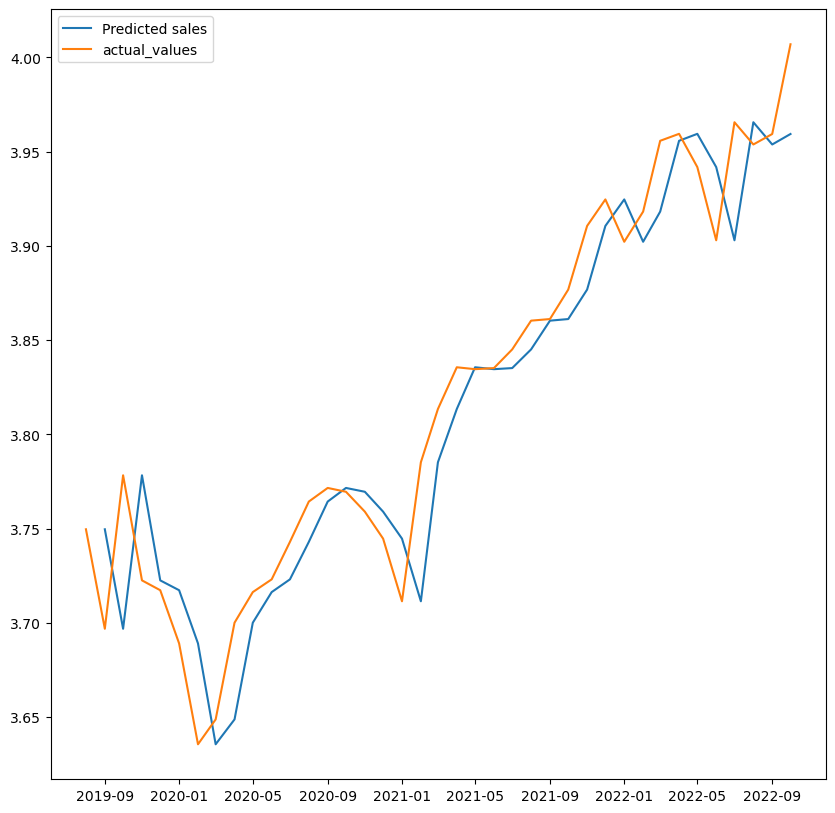

In [25]:
pred=arima_model.predict(1,len(mc_df)-1,typ='levels')
print('mae',mean_absolute_error(mc_df[1:],pred))
print('rmse',np.sqrt(mean_squared_error(mc_df[1:],pred)))
plt.figure(figsize=(10,10))
plt.plot(pred,label='Predicted sales')
plt.plot(mc_df['microbusiness_density'],label='actual_values')
plt.legend()
plt.show()

SUBMISSION

In [26]:
s= {}
for i in range(len(pred)):
    s['row_id']=df_new.row_id[i]
    s['Microbusiness Density']=pd.Series(pred)
submission=pd.DataFrame(s)
submission.to_csv('submission.csv',index = False)
submission

,row_id,Microbusiness Density
2019-09-01,1001_2022-09-01,3.749621
2019-10-01,1001_2022-09-01,3.696846
2019-11-01,1001_2022-09-01,3.778263
2019-12-01,1001_2022-09-01,3.722510
2020-01-01,1001_2022-09-01,3.717284
2020-02-01,1001_2022-09-01,3.689041
2020-03-01,1001_2022-09-01,3.635546
2020-04-01,1001_2022-09-01,3.648742
2020-05-01,1001_2022-09-01,3.700048
2020-06-01,1001_2022-09-01,3.716288
